# Morse grid imports

Here we look at applied examples to import data for use in Dr Peter Morse 3D visualtsation software _(in prep.)_. Data must be exported as $1800 \times 3600$ px png files. This might change in future. 

Generally, the code in this tutorial runs rather slow as there is a large amount of interpolation. Have patience. 

Folder `../local` is used to download data and export pngs. 

In [1]:
#import warnings
#warnings.filterwarnings('ignore')

#config_file = "../agrid/agrid.py"
#with open(config_file) as f:
#    code = compile(f.read(), config_file, 'exec')
#    exec(code, globals(), locals())

# ... or use you Python path or present working directory:
import sys
sys.path.append('..')
from agrid.agrid import *



import vtk
from vtk.util.numpy_support import vtk_to_numpy

/Users/tobiasstal/anaconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/tobiasstal/anaconda3/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
from agrid.morse_export import export_morse_png

## SMEAN

Download the mantel model from from Becker and Boschi, The University of Texas at Austin. See original paper [Becker and_Boschi 2002](http://www-udc.ig.utexas.edu/external/becker/becker_and_boschi_2002.pdf) for details.

In [3]:
! mkdir -p ../../data/smean
! wget -nc http://www-udc.ig.utexas.edu/external/becker/ftp/smean_grd.tgz \
    -O ../../data/smean/smean_grd.tgz
! tar -xvzf ../../data/smean/smean_grd.tgz -C ../../data/

File ‘../../data/smean/smean_grd.tgz’ already there; not retrieving.
x smean/
x smean/dvs.8.grd
x smean/dvs.15.grd
x smean/dvs.29.grd
x smean/dvs.17.grd
x smean/dvs.28.grd
x smean/convert
x smean/dvs.27.grd
x smean/dvs.22.grd
x smean/dvs.20.grd
x smean/dvs.6.grd
x smean/dvs.11.grd
x smean/dvs.1.grd
x smean/dvs.13.grd
x smean/depths.dat
x smean/dvs.9.grd
x smean/dvs.24.grd
x smean/dvs.7.grd
x smean/dvs.14.grd
x smean/dvs.4.grd
x smean/dvs.23.grd
x smean/README
x smean/dvs.5.grd
x smean/dvs.19.grd
x smean/dvs.16.grd
x smean/dvs.25.grd
x smean/dvs.10.grd
x smean/dvs.21.grd
x smean/dvs.12.grd
x smean/dvs.18.grd
x smean/dvs.26.grd
x smean/dvs.2.grd
x smean/dvs.3.grd


In this example, the data is global and we define a grid with the right rsolution from start. However, as we will see later, we could work on regional data as well. The exported png will always have a global coverage with alpha covering the excluded areas. 

We read depth values for smean from a provided ascii file. However we also have a regular depth dimention, defined as regular 50km depths. 

In [4]:
smean_depths = km * np.loadtxt('../../data/smean/depths.dat')[::-1]

world = Grid(crs_tgt = 4326, 
             left= -180, up=90, down= -90, right=180.0, 
             res=(0.099999999999,0.099999999999), 
             depths = smean_depths)

array = np.empty((world.ny, world.nx, world.ds.coords['Z'].size))
array[:] = np.nan
print(world.ds)

<xarray.Dataset>
Dimensions:  (RGB: 3, X: 3599, Y: 1799, Z: 29)
Coordinates:
  * X        (X) float32 -180.0 -179.89998 -179.79994 ... 179.79997 179.9
  * Y        (Y) float32 89.9 89.79994 89.69989 ... -89.79989 -89.89995 -90.0
  * Z        (Z) float32 50000.0 150000.0 250000.0 ... 2750000.0 2850000.0
  * RGB      (RGB) <U1 'R' 'G' 'B'
    XV       (Y, X) float32 dask.array<shape=(1799, 3599), chunksize=(179, 359)>
    YV       (Y, X) float32 dask.array<shape=(1799, 3599), chunksize=(179, 359)>
    lat      (Y, X) float32 dask.array<shape=(1799, 3599), chunksize=(179, 359)>
    lon      (Y, X) float32 dask.array<shape=(1799, 3599), chunksize=(179, 359)>
Data variables:
    *empty*


Now, we can read SMEAN files. set_center alows us to read 0-360 as -180 - 180 lon. read_grid uses default nearest neighbour interpolation of datapoints to fit the predefined Morse grid. 

In [ ]:
for i, a in enumerate(world.ds['Z'].values):
    print(world.ds['Z'].size - i, a//km, end=', ')
    index_name = world.ds['Z'].size - i # Get right file name for each depth
    fname = '../../data/smean/dvs.%s.grd'%(index_name)
    if os.path.isfile(fname):
        array[:,:,i] = world.read_grid(fname, xyz = ('lon','lat','z'), set_center = True)
        
array /= 100    #"The grid file values are given are percentage v_S wave 
                #speed variation related to PREM, with layer averages removed."
        
world.ds['SMEAN'] = (('Y', 'X', 'Z'), array)

Finally, we export the 3D grids as png files for each depth slice. We store a set of original depth slices in ''morse/smean/z_orig/' and also the interpolated depth slices in 'morse/smean/z_even/'. This might take some time. 

In [ ]:
smean_min = np.nanmin(world.ds['SMEAN'].values)
smean_max = np.nanmax(world.ds['SMEAN'].values)

print(smean_min, smean_max)

In [ ]:
import pickle
pickle.dump(world, open( "../local/world.p", "wb" ))
#world = pickle.load( open( "../local/world.p", "rb" ) )

In [ ]:
! mkdir -p ../local/morse/smean

In [ ]:
for i, z in enumerate(world.ds['Z']):
    report = export_morse_png(world,
                        data = world.ds['SMEAN'].isel(Z=i).values, 
                        png_name = '../local/morse/smean/%04d_%s_smean.png'%(int(z)//km, i+1), 
                        v_min = smean_min, v_max = smean_max, 
                        set_geometry = False)
    print(report)
    with open("../local/morse/smean/log_smean.txt", "a") as log_file:
        log_file.write(report)
    

## GLAD M15

Now let's import the model from [Bozdağ et al (2016)](https://academic.oup.com/gji/article/207/3/1739/2404568). Unfortunately, it appears that the data is not availible from any open repo (?!), but I belive that the group is willing to assist if contacted. 

The SMEAN data was easy to import, but exporting the GLAD-M15 data is more compicated as I only get access to an unstructured grid, in a normalised space. 

In [ ]:
# load a vtk file to reader
reader = vtk.vtkXMLUnstructuredGridReader()
reader.SetFileName('../local/GLAD-M15/reg_1_dvsv.vtu')
reader.Update()

# Get the coordinates of nodes in the mesh
nodes_vtk_array= reader.GetOutput().GetPoints().GetData()

#The data field is the first scalar in the vtu file
data_vtk_array = reader.GetOutput().GetPointData().GetArray(0)

print(data_vtk_array, nodes_vtk_array)

We get two arrays. Note that sizes are equal (Number Of Tuples: 4712064 and Number Of Tuples: 4712064) and the coordinate are 3D (NumberOfComponents: 3). Read coordinates and data as numpy arrays and have a look: 

In [ ]:
nodes_numpy_array = vtk_to_numpy(nodes_vtk_array)
X, Y, Z = nodes_numpy_array[:,0] , nodes_numpy_array[:,1] , nodes_numpy_array[:,2]
V = vtk_to_numpy(data_vtk_array)

print(X[:10],Y[:10],Z[:10],V[:10], sep='\n\n')

The coordinates are stored in the range [-1..1]. We assume a spherical Earth and compute an array with every points distance from centre. Function `sphere_to_layer()` takes a slice from the sphere and save to a 2D array. delta_r should be as small as possible, for best vertical resolution, but if too few points are used the vertical resolution gets bad. 

We loop through the harmonics of the sphere and read all points within a spherical shell defined by the radius +/- delta_r

In [ ]:
def sphere_to_layer(d, R, V, LAT, LON, xxx, yyy, 
                    delta_r = 32*km, 
                    min_s = 5000,
                    r_earth =  (6357*km + 6378*km) / 2, 
                    interpolation = 'nearest'):
    
    A = np.zeros_like(xxx).astype('float')
    A[:] = np.nan
    upper = 1-(d-delta_r)/r_earth
    lower = 1-(d+delta_r)/r_earth
    S = (R > lower) & (R < upper) # Select points in spherical shell
    s_sum = np.count_nonzero(S) # Check how many points in shell

    if s_sum >= min_s:
        A = interpolate.griddata((LON[S], LAT[S]),
                V[S], (xxx, yyy), method = interpolation)
    print(d//1000, 'km \t N=', sum(S),u'\t \N{BLACK RIGHT-POINTING TRIANGLE}', np.nanmean(A))
    return np.flipud(A) #Because ulike lat, rows start from top. 

R = np.sqrt(X*X + Y*Y + Z*Z) # The distance from each point to centre of spherical Earth. 

LAT = world.shape3[0]/180 * (np.arccos( Z / R) * 180/np.pi) 
LON = world.shape3[1]/360 * (np.arctan2(Y, X) * 180/np.pi + 180)

xxx, yyy = np.meshgrid(range(0, world.shape3[1]), range(world.shape3[0], 0, -1)) 

glad = np.zeros(world.shape3) # self.shape3 is a tuple of the models dimensions

for i, d in enumerate(world.ds['Z'].values):
    glad[:,:,i] = sphere_to_layer(d, R, V, LAT, LON, xxx, yyy)

Unfortunately there are not enugh data points at 1350, 1450, 2150 and 2250 km depth. We'd need to look in a broad spherical shell to get datapoints: 

In [ ]:
missing_i, missing_d = [], []

for i in range(glad.shape[2]):
    if (np.count_nonzero(np.isnan(glad[:,:,i]) ) > 1000):
        missing_i.append(i)
        missing_d.append(world.ds['Z'].values[i])
      
for i,d in zip(missing_i, missing_d):
    print(i, end=' ')
    glad[:,:,i] = sphere_to_layer(d, R, V, LAT, LON, xxx, yyy, delta_r = 45*km)    

However, we can be more precise with the first layer. 

In [ ]:
glad[:,:,0] = sphere_to_layer(50*km, R, V, LAT, LON, xxx, yyy, delta_r = 14*km)   
glad[:,:,1] = sphere_to_layer(150*km, R, V, LAT, LON, xxx, yyy, delta_r = 20*km)   

We save the array to the object and have a look. 

In [ ]:
world.ds['GLAD'] = (('Y', 'X', 'Z'), glad)
glad_min = np.nanmin(world.ds['GLAD'].values)
glad_max = np.nanmax(world.ds['GLAD'].values)

print(glad_min, glad_max)
print(smean_min, smean_max)

z_map = 0
world.map_grid(world.ds['GLAD'].isel(Z=z_map), cmap='magma_r', vmin=-0.06, vmax=0.06)
world.map_grid(world.ds['SMEAN'].isel(Z=z_map), cmap='magma_r', vmin=-0.06, vmax=0.06)

In [ ]:
world.ds['DIFF'] = world.ds['GLAD']-world.ds['SMEAN']

diff_min = np.nanmin(world.ds['DIFF'].values)
diff_max = np.nanmax(world.ds['DIFF'].values)

print(diff_min, diff_max)

world.map_grid(world.ds['DIFF'].isel(Z=z_map), cmap='BrBG', vmin=-0.06, vmax=0.06)

In [ ]:
! mkdir -p ../local/morse/glad

In [ ]:
for i, z in enumerate(world.ds['Z']):
    report = export_morse_png(world, world.ds['GLAD'].isel(Z=i).values, '../local/morse/glad/%04d_%s_glad.png'%(int(z)//km, i+1), 
                          v_min = glad_min, v_max = glad_max, set_geometry = False)
    with open("../local/morse/glad/log.txt", "a") as log_file:
        log_file.write(report)
    print(report)
    

Save the grid: 

In [ ]:
world.save(world.ds, '../local/smean_and_glad.nc')

We could also interpolate new depth values to make a regular 3D grid. 

In [ ]:
world.ds['Z_NEW'] = range(0,2850*km, 100*km)

world.ds['SMEAN_INTER'] = ( ('Y', 'X', 'Z'), 
                           world.change_coord(world.ds['SMEAN'], world.ds['Z'], world.ds['Z_NEW']) )

In [ ]:
world.ds

# AuSREM

Australian crustal and lithospheric seismic model.

Can be downloaded from http://rses.anu.edu.au/seismology/AuSREM/Downloads/ We assume a local file: 

In [5]:
fname = '../local/ausrem_SV_100.txt'
data = world.read_ascii(fname)

Make a mask, as the 'nearest neigbur' interpolation tested, will extrapolate values to all cells.

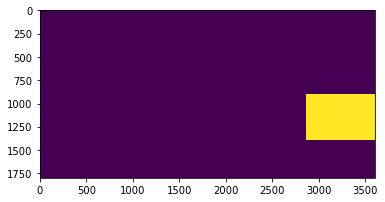

In [6]:
alpha_master = np.isfinite(data)

plt.imshow(alpha_master)
plt.show()

Here, we test a number of different formats for the output png file: 

In [8]:
for _format in ['L', 'LA', 'RGB', 'RGBA']:
    for _bit_depth in [8, 16]:
        for _interpol in ['nearest', 'linear', 'cubic']:
            data = world.read_ascii(fname, interpol =_interpol)
            
            if _interpol == 'nearest':
                how_confine = 'mask'
                mask_to_value = np.nan
            else:
                how_confine = 'input'
                mask_to_value = None
            
            report = export_morse_png(world,
                          data = data, 
                          png_format = _format,
                          png_name = '../local/AuSREM/AuSREM_100km_%s_%sbit_%s.png'%( _interpol,_bit_depth,_format),
                          interpol_method =  _interpol,
                          confine_data = how_confine,
                          confine_mask = alpha_master,
                        mask_to_value = mask_to_value,
                          v_min = 4, v_max = 5, 
                          clip=True,
                          set_geometry = False, 
                          bit_depth=_bit_depth)

            print(report)
            with open("../local/AuSREM_log.txt", "a") as log_file:
                log_file.write(report)

nan 0.0
../local/AuSREM/AuSREM_100km_nearest_8bit_L.png
greyscale: True
alpha: False
planes: 1
bitdepth: 8
interlace: 0
size: (3599, 1799)
../local/AuSREM/AuSREM_100km_nearest_8bit_L.png 
min v: 4 max v: 5 bit depth: 8
bands: (1799, 3599) interpolation: nearest
data 	  norm 	  to png 	 png 
4.09 	  0.09 	 22.62 	  0 
4.81 	  0.81 	 207.37 	  207 
 

nan 0.0
../local/AuSREM/AuSREM_100km_linear_8bit_L.png
greyscale: True
alpha: False
planes: 1
bitdepth: 8
interlace: 0
size: (3599, 1799)
../local/AuSREM/AuSREM_100km_linear_8bit_L.png 
min v: 4 max v: 5 bit depth: 8
bands: (1799, 3599) interpolation: linear
data 	  norm 	  to png 	 png 
4.09 	  0.09 	 22.71 	  0 
4.81 	  0.81 	 207.00 	  207 
 

nan 0.0
../local/AuSREM/AuSREM_100km_cubic_8bit_L.png
greyscale: True
alpha: False
planes: 1
bitdepth: 8
interlace: 0
size: (3599, 1799)
../local/AuSREM/AuSREM_100km_cubic_8bit_L.png 
min v: 4 max v: 5 bit depth: 8
bands: (1799, 3599) interpolation: cubic
data 	  norm 	  to png 	 png 
4.09 	  0.09 

FileNotFoundError: [Errno 2] No such file or directory: '../local/AuSREM/AuSREM_100km_cubic_8bit_RGBA.png'

In [ ]:
!sips -g all ../local/AuSREM/AuSREM_100km_nearest_16bit_L.png
#!open ../local/new/AuSREM_100km_nearest_16bit_L.png